In [2]:
import cv2
import tensorrt as trt
import torch
import numpy as np
from collections import OrderedDict,namedtuple

class TRT_engine():
    def __init__(self, weight) -> None:
        self.imgsz = [416,416]
        self.weight = weight
        self.device = torch.device('cuda:0')
        self.init_engine()

    def init_engine(self):
        # Infer TensorRT Engine
        self.Binding = namedtuple('Binding', ('name', 'dtype', 'shape', 'data', 'ptr'))
        self.logger = trt.Logger(trt.Logger.INFO)
        trt.init_libnvinfer_plugins(self.logger, namespace="")
        with open(self.weight, 'rb') as self.f, trt.Runtime(self.logger) as self.runtime:
            self.model = self.runtime.deserialize_cuda_engine(self.f.read())
        self.bindings = OrderedDict()
        self.fp16 = False
        for index in range(self.model.num_bindings):
            self.name = self.model.get_binding_name(index)
            self.dtype = trt.nptype(self.model.get_binding_dtype(index))
            self.shape = tuple(self.model.get_binding_shape(index))
            self.data = torch.from_numpy(np.empty(self.shape, dtype=np.dtype(self.dtype))).to(self.device)
            self.bindings[self.name] = self.Binding(self.name, self.dtype, self.shape, self.data, int(self.data.data_ptr()))
            if self.model.binding_is_input(index) and self.dtype == np.float16:
                self.fp16 = True
        self.binding_addrs = OrderedDict((n, d.ptr) for n, d in self.bindings.items())
        self.context = self.model.create_execution_context()

    def letterbox(self,im,color=(114, 114, 114), auto=False, scaleup=True, stride=32):
        # Resize and pad image while meeting stride-multiple constraints
        shape = im.shape[:2]  # current shape [height, width]
        new_shape = self.imgsz
        if isinstance(new_shape, int):
            new_shape = (new_shape, new_shape)
        # Scale ratio (new / old)
        self.r = min(new_shape[0] / shape[0], new_shape[1] / shape[1])
        if not scaleup:  # only scale down, do not scale up (for better val mAP)
            self.r = min(self.r, 1.0)
        # Compute padding
        new_unpad = int(round(shape[1] * self.r)), int(round(shape[0] * self.r))
        self.dw, self.dh = new_shape[1] - new_unpad[0], new_shape[0] - new_unpad[1]  # wh padding
        if auto:  # minimum rectangle
            self.dw, self.dh = np.mod(self.dw, stride), np.mod(self.dh, stride)  # wh padding
        self.dw /= 2  # divide padding into 2 sides
        self.dh /= 2
        if shape[::-1] != new_unpad:  # resize
            im = cv2.resize(im, new_unpad, interpolation=cv2.INTER_LINEAR)
        top, bottom = int(round(self.dh - 0.1)), int(round(self.dh + 0.1))
        left, right = int(round(self.dw - 0.1)), int(round(self.dw + 0.1))
        self.img = cv2.copyMakeBorder(im, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)  # add border
        return self.img,self.r,self.dw,self.dh

    def preprocess(self,image):
        self.img,self.r,self.dw,self.dh = self.letterbox(image)
        self.img = self.img.transpose((2, 0, 1))
        self.img = np.expand_dims(self.img,0)
        self.img = np.ascontiguousarray(self.img)
        self.img = torch.from_numpy(self.img).to(self.device)
        self.img = self.img.float()
        return self.img

    def predict(self,img,threshold):
        img = self.preprocess(img)
        self.binding_addrs['images'] = int(img.data_ptr())
        self.context.execute_v2(list(self.binding_addrs.values()))
        nums = self.bindings['num_dets'].data[0].tolist()
        boxes = self.bindings['det_boxes'].data[0].tolist()
        scores =self.bindings['det_scores'].data[0].tolist()
        classes = self.bindings['det_classes'].data[0].tolist()
        num = int(nums[0])
        new_bboxes = []
        for i in range(num):
            if(scores[i] < threshold):
                continue
            xmin = (boxes[i][0] - self.dw)/self.r
            ymin = (boxes[i][1] - self.dh)/self.r
            xmax = (boxes[i][2] - self.dw)/self.r
            ymax = (boxes[i][3] - self.dh)/self.r
            new_bboxes.append([classes[i],scores[i],xmin,ymin,xmax,ymax])
        return new_bboxes

def visualize(img,bbox_array):
    for temp in bbox_array:
        xmin = int(temp[2])
        ymin = int(temp[3])
        xmax = int(temp[4])
        ymax = int(temp[5])
        clas = int(temp[0])
        score = temp[1]
        cv2.rectangle(img,(xmin,ymin),(xmax,ymax), (105, 237, 249), 2)
        img = cv2.putText(img, "class:"+str(clas)+" "+str(round(score,2)), (xmin,int(ymin)-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (105, 237, 249), 1)
    return img

trt_engine = TRT_engine("./engine/best1.engine")
trt_engine2 = TRT_engine("./engine/best2.engine")
# trt_engine = TRT_engine("./best1.engine")


[01/15/2023-12:19:16] [TRT] [I] Loaded engine size: 71 MiB
[01/15/2023-12:19:17] [TRT] [I] [MemUsageChange] Init cuBLAS/cuBLASLt: CPU +841, GPU +362, now: CPU 1399, GPU 8547 (MiB)
[01/15/2023-12:19:17] [TRT] [I] [MemUsageChange] Init cuDNN: CPU +129, GPU +60, now: CPU 1528, GPU 8607 (MiB)
[01/15/2023-12:19:17] [TRT] [W] TensorRT was linked against cuDNN 8.6.0 but loaded cuDNN 8.5.0
[01/15/2023-12:19:17] [TRT] [I] [MemUsageChange] TensorRT-managed allocation in engine deserialization: CPU +0, GPU +70, now: CPU 0, GPU 70 (MiB)
[01/15/2023-12:19:18] [TRT] [I] [MemUsageChange] Init cuBLAS/cuBLASLt: CPU +0, GPU +8, now: CPU 2540, GPU 9089 (MiB)
[01/15/2023-12:19:18] [TRT] [I] [MemUsageChange] Init cuDNN: CPU +0, GPU +8, now: CPU 2540, GPU 9097 (MiB)
[01/15/2023-12:19:18] [TRT] [W] TensorRT was linked against cuDNN 8.6.0 but loaded cuDNN 8.5.0
[01/15/2023-12:19:18] [TRT] [I] [MemUsageChange] TensorRT-managed allocation in IExecutionContext creation: CPU +0, GPU +26, now: CPU 0, GPU 96 (MiB)


/tmp/ipykernel_31519/529105513.py:24: DeprecationWarning: Use get_tensor_name instead.
  self.name = self.model.get_binding_name(index)
/tmp/ipykernel_31519/529105513.py:25: DeprecationWarning: Use get_tensor_dtype instead.
  self.dtype = trt.nptype(self.model.get_binding_dtype(index))
/tmp/ipykernel_31519/529105513.py:26: DeprecationWarning: Use get_tensor_shape instead.
  self.shape = tuple(self.model.get_binding_shape(index))
/tmp/ipykernel_31519/529105513.py:29: DeprecationWarning: Use get_tensor_mode instead.
  if self.model.binding_is_input(index) and self.dtype == np.float16:


[01/15/2023-12:19:18] [TRT] [I] [MemUsageChange] Init cuDNN: CPU +0, GPU +8, now: CPU 2547, GPU 9215 (MiB)
[01/15/2023-12:19:18] [TRT] [W] TensorRT was linked against cuDNN 8.6.0 but loaded cuDNN 8.5.0
[01/15/2023-12:19:18] [TRT] [I] [MemUsageChange] TensorRT-managed allocation in IExecutionContext creation: CPU +0, GPU +25, now: CPU 0, GPU 192 (MiB)
[01/15/2023-12:19:18] [TRT] [W] CUDA lazy loading is not enabled. Enabling it can significantly reduce device memory usage. See `CUDA_MODULE_LOADING` in https://docs.nvidia.com/cuda/cuda-c-programming-guide/index.html#env-vars


In [14]:
import time
img = cv2.imread("../yolo/images/00011.jpg")
t1 = time.time()

results = trt_engine.predict(img,threshold=0.5)
print(time.time()-t1)
# img = visualize(img,results)


0.00923919677734375


In [33]:
def predict_yolo_rt(rt_infer, origin_img):
    output = {
        "box":list(),
        "image":list(),
    }
    results = rt_infer.predict(origin_img,threshold=0.5)
    
    for res in results:
        xyxy = res[2:]
        c1, c2 = (int(xyxy[0]), int(xyxy[1])), (int(xyxy[2]), int(xyxy[3]))
        output["box"].append([c1, c2])
        output["image"].append(origin_img[c1[1]:c2[1], c1[0]:c2[0]])
    return output

In [36]:
crop_output = predict_yolo_rt(trt_engine, img)
if crop_output["box"] != []:
    labels = list()
    for index, crop_img in enumerate(crop_output["image"]):
        if index > 6:
            break
        seg_output = predict_yolo_rt(trt_engine2, crop_img)

In [26]:
results

[[0,
  0.95703125,
  854.4230769230769,
  564.8076923076923,
  949.0384615384615,
  614.4230769230769]]

In [15]:
results[0][2:]

[854.4230769230769, 564.8076923076923, 949.0384615384615, 614.4230769230769]

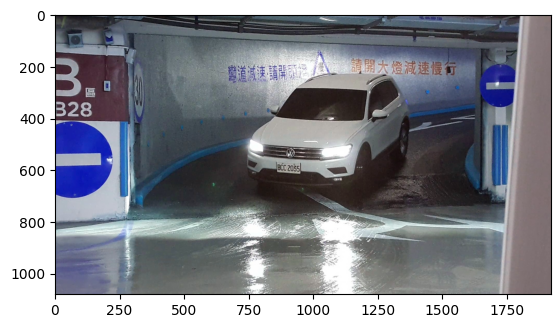

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.imshow(img)
plt.show()

In [17]:
xyxy = results[0][2:]
c1, c2 = (int(xyxy[0]), int(xyxy[1])), (int(xyxy[2]), int(xyxy[3]))

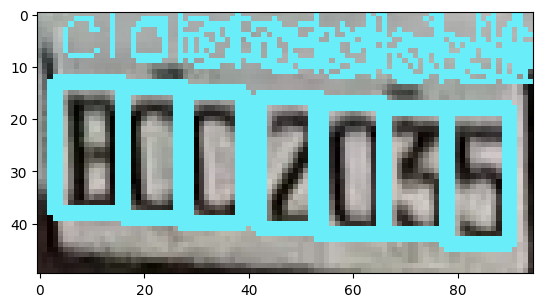

In [23]:
seg_img = img[c1[1]:c2[1], c1[0]:c2[0]]
plt.imshow(seg_img)
plt.show()

In [24]:
seg_result = trt_engine2.predict(seg_img,threshold=0.5)

In [25]:
seg_result

[[11,
  0.9560546875,
  65.9405048076923,
  18.269230769230766,
  77.8155048076923,
  41.27704326923077],
 [11,
  0.955078125,
  77.70132211538461,
  18.640324519230766,
  89.6905048076923,
  43.161057692307686],
 [11,
  0.947265625,
  27.874849759615383,
  15.329026442307692,
  38.99338942307692,
  39.450120192307686],
 [11,
  0.93701171875,
  15.899939903846153,
  14.244290865384615,
  27.061298076923077,
  38.30829326923077],
 [11,
  0.9248046875,
  2.840294471153846,
  12.98828125,
  15.286207932692307,
  37.28064903846153],
 [11,
  0.91796875,
  53.26622596153846,
  16.89903846153846,
  65.9405048076923,
  41.105769230769226],
 [11,
  0.904296875,
  41.73377403846153,
  16.385216346153847,
  52.980769230769226,
  40.30649038461538]]

In [ ]:
for crop_box, label in zip(crop_output["box"], labels):